In [1]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, to_timestamp, month
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
yellow_20 = spark.read.load('2020_Yellow_Taxi_Trip_Data.csv',format='csv', sep=',', inferSchema='true', header='true')

In [3]:
yellow_20.count()

24648499

In [4]:
yellow_20.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [5]:
yellow_20.limit(5).toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,01/01/2020 12:28:15 AM,01/01/2020 12:33:03 AM,1,1.2,1,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1,01/01/2020 12:35:39 AM,01/01/2020 12:43:04 AM,1,1.2,1,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1,01/01/2020 12:47:41 AM,01/01/2020 12:53:52 AM,1,0.6,1,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1,01/01/2020 12:55:23 AM,01/01/2020 01:00:14 AM,1,0.8,1,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2,01/01/2020 12:01:58 AM,01/01/2020 12:04:16 AM,1,0.0,1,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [6]:
yellow_20 = yellow_20.withColumn('tpep_pickup_datetime', to_timestamp(col('tpep_pickup_datetime'), 'MM/dd/yyyy hh:mm:ss a'))
yellow_20 = yellow_20.withColumn('tpep_dropoff_datetime', to_timestamp(col('tpep_dropoff_datetime'), 'MM/dd/yyyy hh:mm:ss a'))

yellow_20 = yellow_20.filter(yellow_20.tpep_pickup_datetime.isNotNull())
yellow_20 = yellow_20.filter(yellow_20.tpep_dropoff_datetime.isNotNull())

yellow_20 = yellow_20.withColumn('trip_seconds',col("tpep_dropoff_datetime").cast("long") - col('tpep_pickup_datetime').cast("long"))
yellow_20 = yellow_20.withColumn('month', month(col('tpep_pickup_datetime')))

yellow_20 = yellow_20.filter(yellow_20.trip_distance.isNotNull())
yellow_20 = yellow_20.filter(yellow_20.total_amount.isNotNull())

yellow_20 = yellow_20.select("month","trip_seconds", "trip_distance", "total_amount")

In [7]:
yellow_20.limit(5).toPandas()

,month,trip_seconds,trip_distance,total_amount
0,1,288,1.2,11.27
1,1,445,1.2,12.30
2,1,371,0.6,10.80
3,1,291,0.8,8.16
4,1,138,0.0,4.80


In [8]:
train, validation, test = yellow_20.randomSplit([0.7, 0.15, 0.15])

In [9]:
train.count()

17251904

In [10]:
validation.count()

3699252

In [11]:
test.count()

3697343

In [12]:
train = train.toPandas()

In [13]:
validation = validation.toPandas()

In [14]:
test = test.toPandas()

In [15]:
train.to_csv('2020_Yellow_Taxi_Trip_Data_training.csv')
test.to_csv('2020_Yellow_Taxi_Trip_Data_test.csv')
validation.to_csv('2020_Yellow_Taxi_Trip_Data_validation.csv')

In [16]:
def streamer(chunk_size, file):
    while True:
        for data in pd.read_csv(file, chunksize=chunk_size):
            data = data[data['trip_distance'].notna()]
            data = data[data['trip_seconds'].notna()]
            data = data[data['month'].notna()]
            data = data[data['total_amount'].notna()]
            x = data[['trip_distance', 'trip_seconds', 'month']].to_numpy()
            y = data['total_amount'].to_numpy()
            yield x, y

In [17]:
# Neural network model with 2 hidden layers using mean absolute error as the loss metric
model = Sequential()

model.add(Dense(16, kernel_initializer='normal',input_dim = 3, activation='relu')) # The Input Layer

# The Hidden Layer
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
model.add(Dense(32, kernel_initializer='normal',activation='relu'))

model.add(Dense(1, kernel_initializer='normal',activation='linear')) # The Output Layer
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________


In [18]:
train_file = '2020_Yellow_Taxi_Trip_Data_training.csv'
validation_file = '2020_Yellow_Taxi_Trip_Data_validation.csv'
chunksize = 10000

In [20]:
# Model runs with a streamer for both the train and validation sets for 10 epochs
lengths = [6676699, 1432518]
history = model.fit(streamer(chunksize, train_file),
          steps_per_epoch=lengths[0]//chunksize,
          epochs=10,
          verbose=2,
          validation_data=streamer(chunksize, validation_file), 
          validation_steps = lengths[1]//chunksize)

Epoch 1/10
667/667 - 10s - loss: 8.6945 - mean_absolute_error: 8.6945 - mse: 4118.8667 - val_loss: 7.5813 - val_mean_absolute_error: 7.5813 - val_mse: 5612.0991
Epoch 2/10
667/667 - 10s - loss: 7.8185 - mean_absolute_error: 7.8185 - mse: 222202.9844 - val_loss: 7.0964 - val_mean_absolute_error: 7.0964 - val_mse: 131765.3906
Epoch 3/10
667/667 - 9s - loss: 7.1901 - mean_absolute_error: 7.1901 - mse: 179097.1875 - val_loss: 7.5703 - val_mean_absolute_error: 7.5703 - val_mse: 3066.6270
Epoch 4/10
667/667 - 9s - loss: 5.7271 - mean_absolute_error: 5.7271 - mse: 2556.9353 - val_loss: 5.4844 - val_mean_absolute_error: 5.4844 - val_mse: 6858.5093
Epoch 5/10
667/667 - 9s - loss: 5.9109 - mean_absolute_error: 5.9109 - mse: 375390.4062 - val_loss: 5.7980 - val_mean_absolute_error: 5.7980 - val_mse: 135902.1250
Epoch 6/10
667/667 - 9s - loss: 6.0552 - mean_absolute_error: 6.0552 - mse: 25291.8398 - val_loss: 6.0827 - val_mean_absolute_error: 6.0827 - val_mse: 13842.7041
Epoch 7/10
667/667 - 9s - 

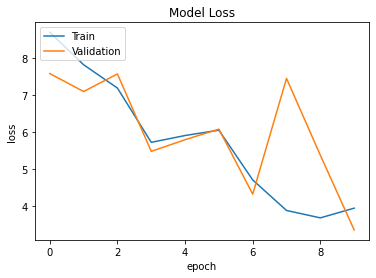

<Figure size 432x288 with 0 Axes>

In [21]:
# Plot of loss over each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('2020_loss.png')

In [22]:
# Test set
test = pd.read_csv('2020_Yellow_Taxi_Trip_Data_test.csv')             
x = test[['trip_distance', 'trip_seconds', 'month']]
y = test['total_amount']

In [23]:
# Saving model in a H5py format
model.save('models/NN_model_2020.h5')

In [24]:
# Predicting values using test set
predictions = model.predict(x)

In [25]:
# Evaluating model using test data
model.evaluate(x)

115542/115542 [==============================] - 91s 788us/step - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00 - mse: 0.0000e+00


[0.0, 0.0, 0.0]

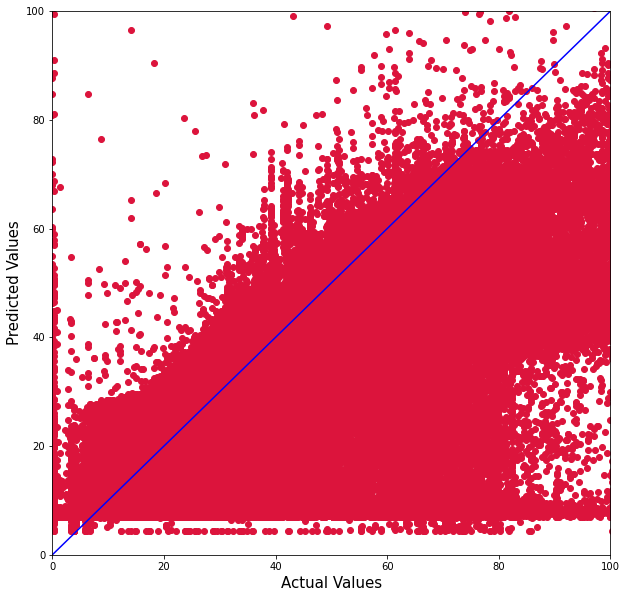

In [26]:
# Plot of actual vs predicted values
y = y.to_numpy()
plt.figure(figsize=(10,10))
plt.scatter(y, predictions, c='crimson')


p1 = max(max(predictions), max(y))
p2 = min(min(predictions), min(y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()